# Курс "Методы современной прикладной статистики"
# 3 курс ФПМИ МФТИ, весна 2022
## Домашнее задание 2. Проверка статистических гипотез.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as spss
import seaborn as sns
import pandas as pd
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina"  # only for retina display

In [2]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize, fmin

### Задача 1

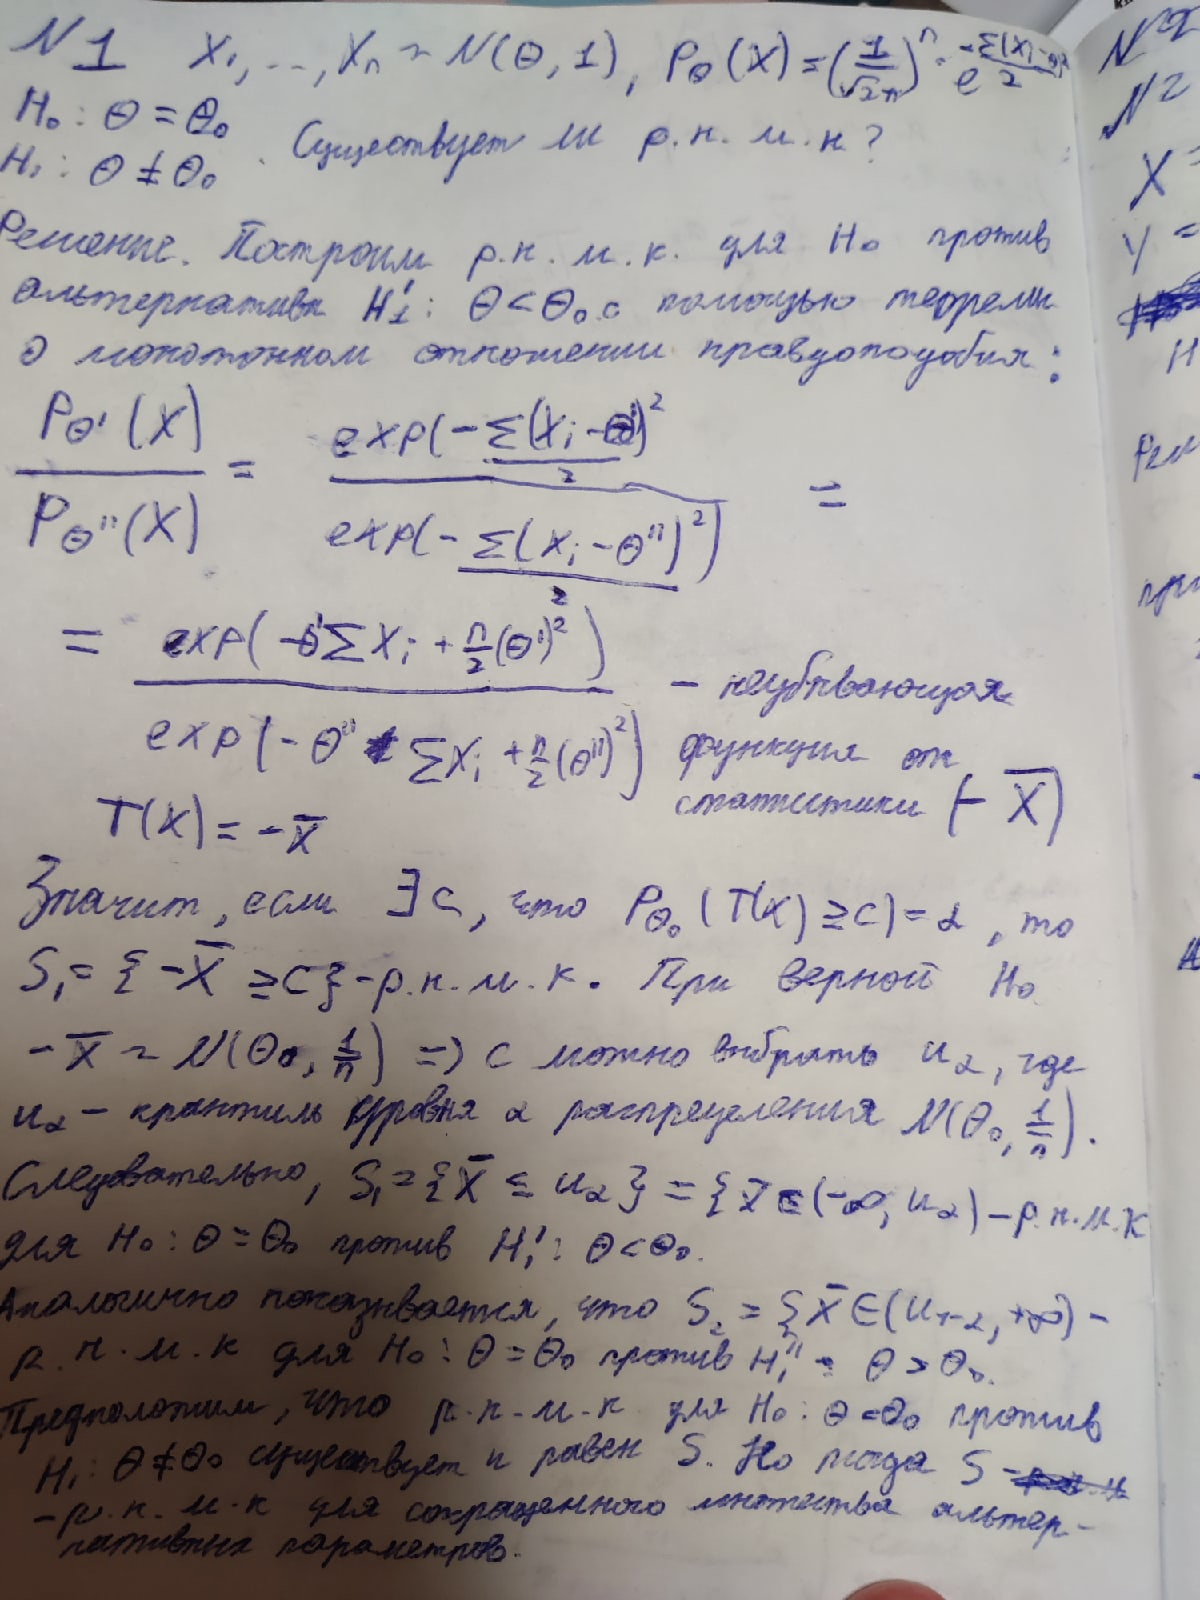

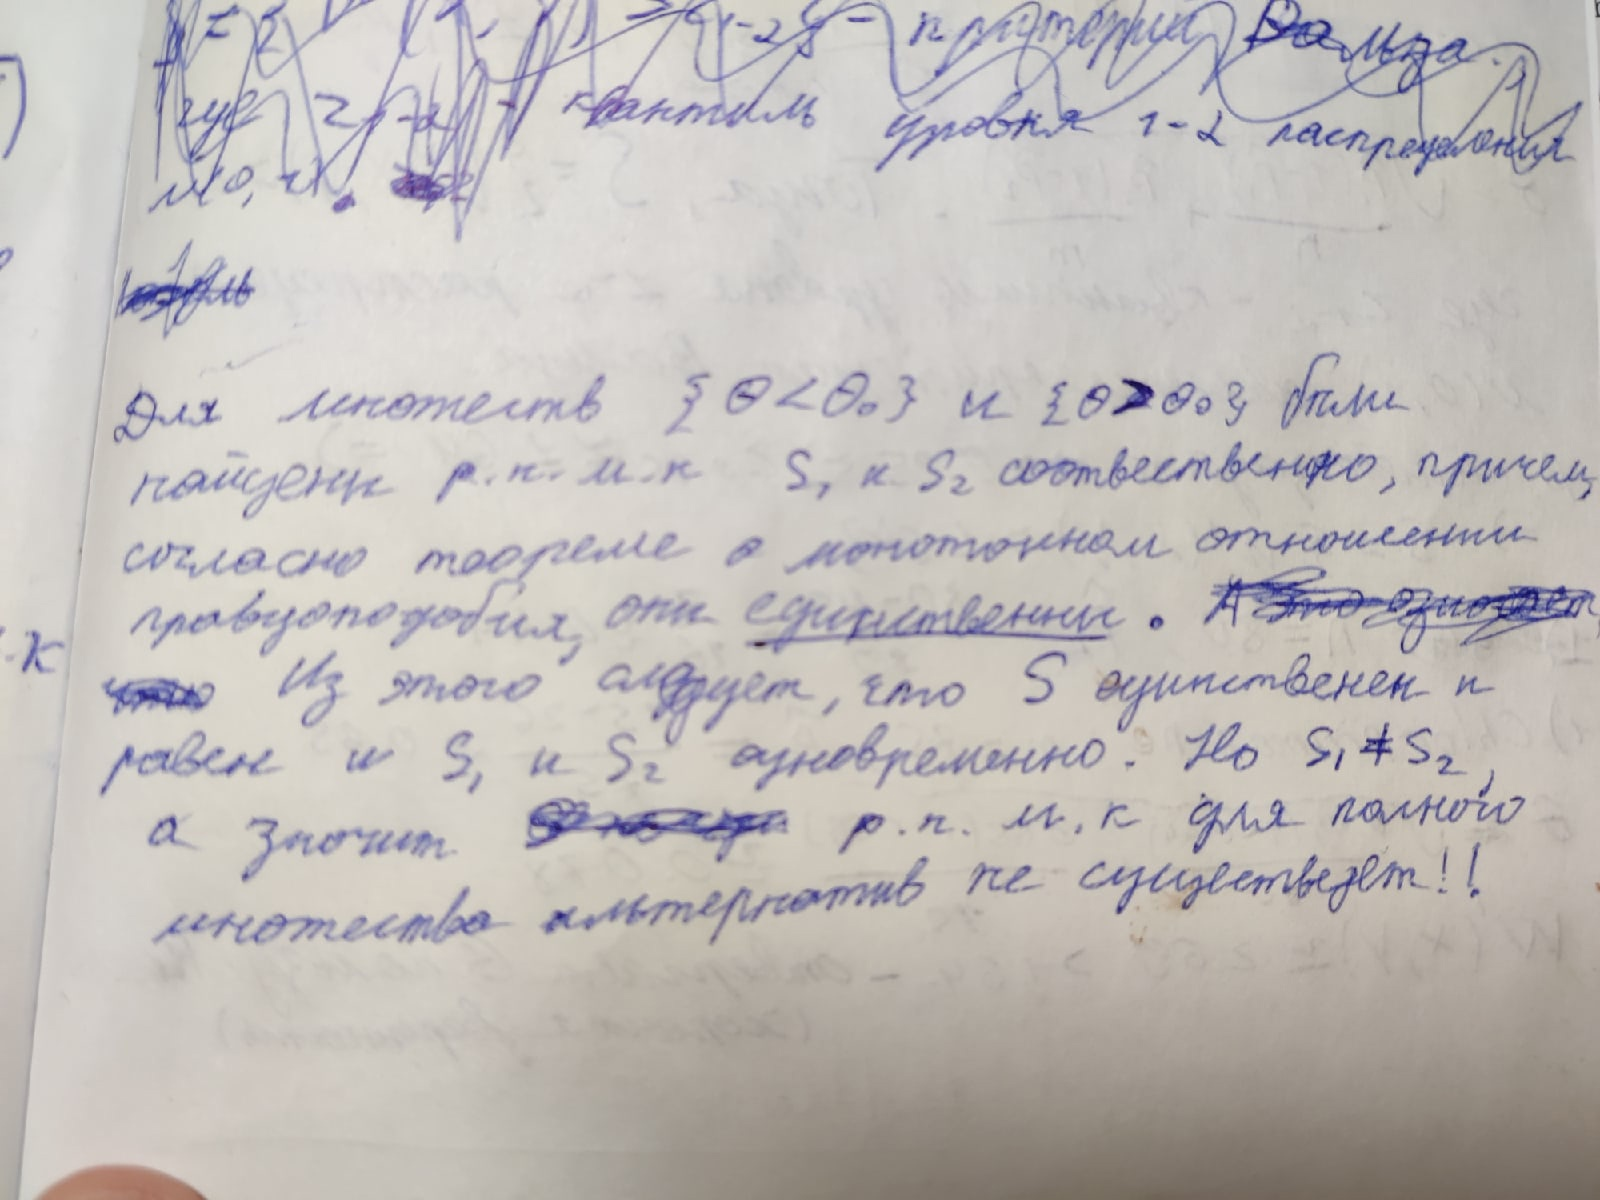

### Задача 2

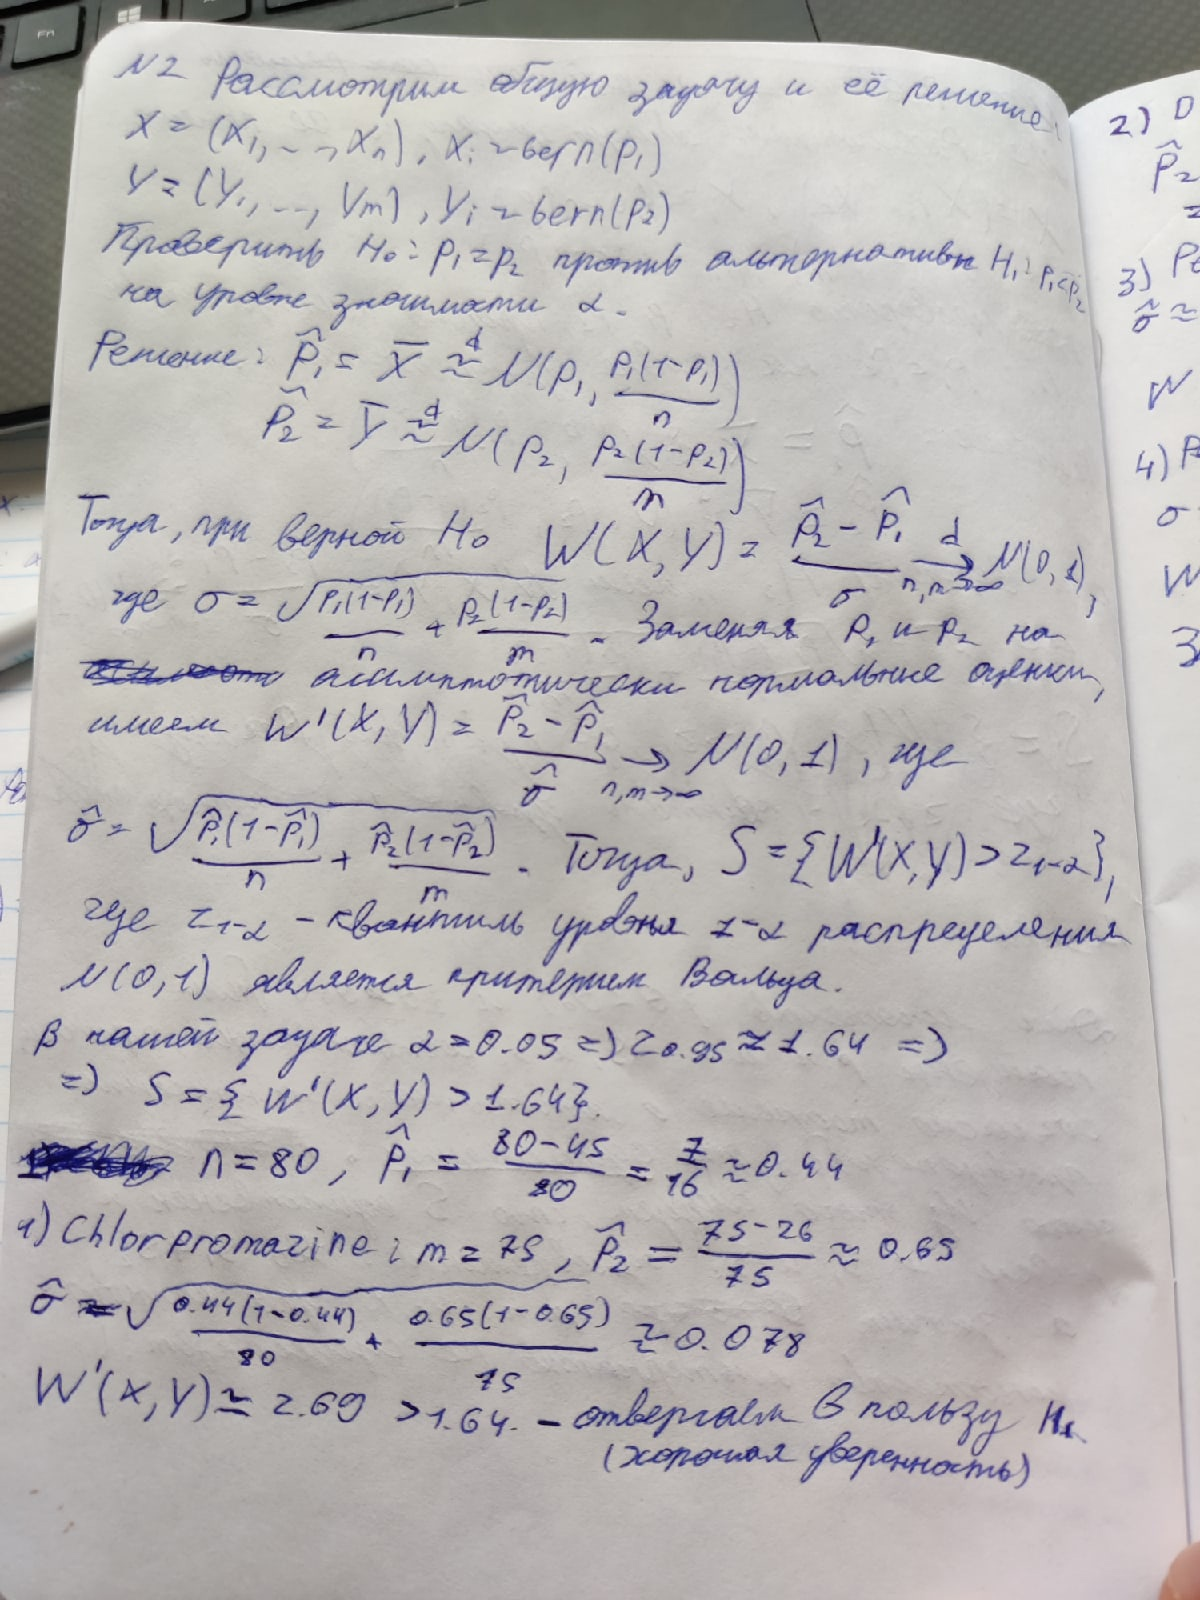

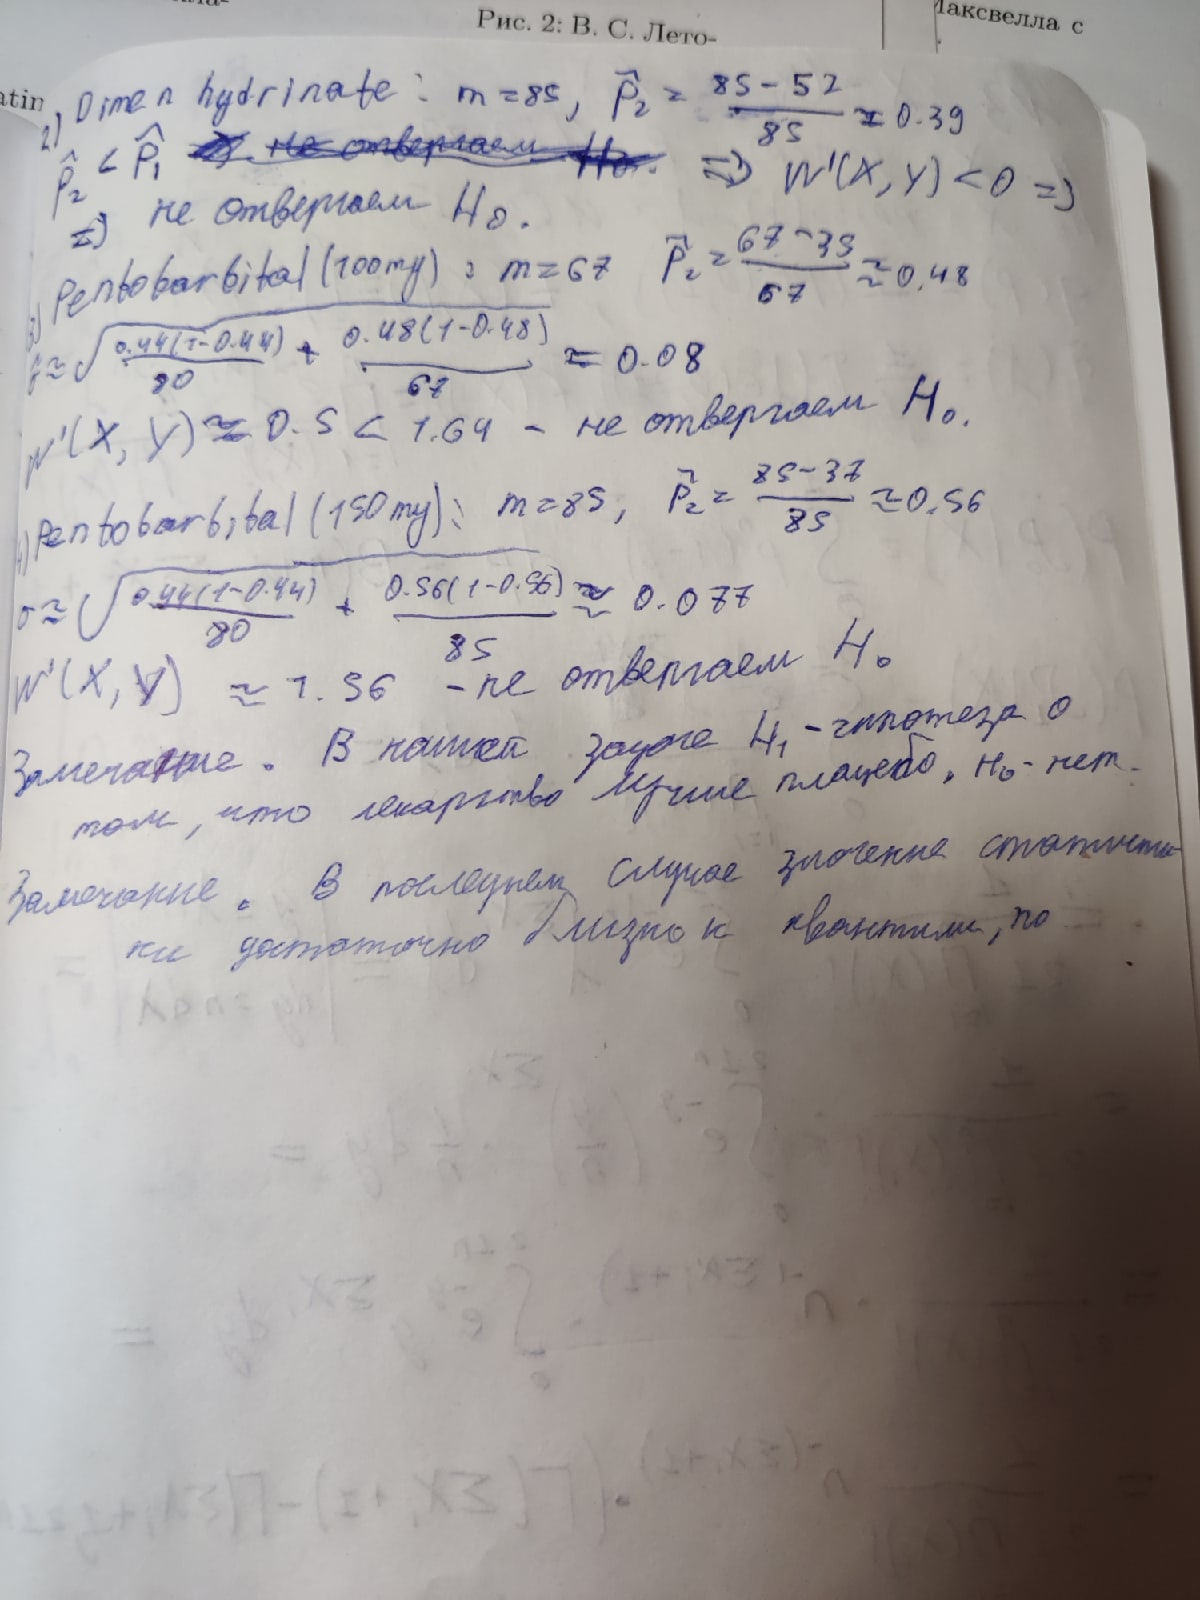

### Задача 3

Посчитаем статистику $K$:

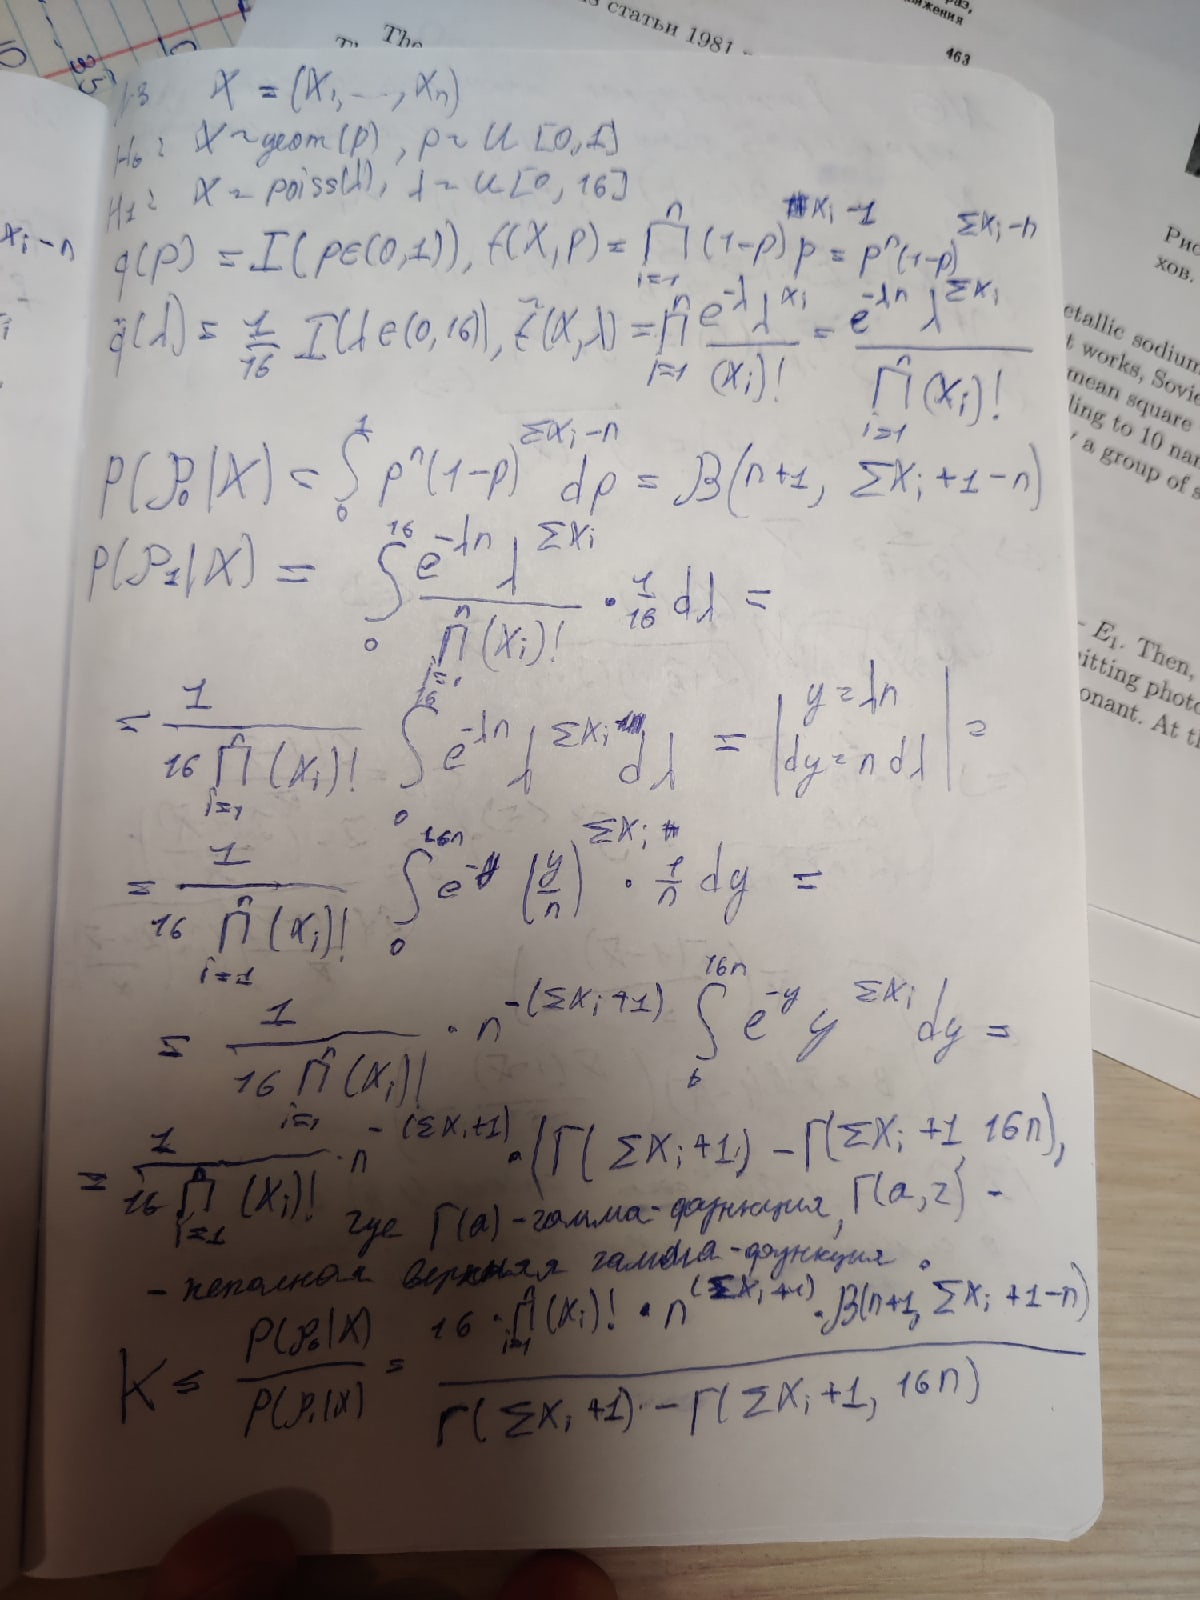

Так как промежуточные значения входе вычисления статистики $K$ являются очень большими, как и значение самой статистики, будем вычислять $ln(K)$ и относительно ее строить критерий.

In [3]:
data = np.load("data2.3.npy")

In [4]:
def calc_log_k(sample):
    def calc_log_fact(val):
        return np.sum(np.log(np.arange(2, int(val) + 1)))
    n = len(sample)
    summ = sample.sum() + 1
    log_facts = np.array([calc_log_fact(val) for val in sample])
    log_num = np.log(16) + np.sum(log_facts) + summ * np.log(n) + spss.betaln(n + 1, summ - n)
    log_denom = spss.gammaln(summ) # введу того, что 16n достаточно большое, вехнюю гамма-функцию можно не учитывать
    return min(log_num - log_denom, 2000)

Построим эмперические распределения статистики $ln(K)$ при верных гипотезах $H_0$ и $H_1$:

In [5]:
num_samples = 10000

In [6]:
param_values1 = sps.uniform(0, 1).rvs(num_samples)
param_values2 = sps.uniform(0, 21).rvs(num_samples)

samples1 = []
samples2 = []

for param1, param2 in zip(param_values1, param_values2):
    samples1.append(sps.geom(param1).rvs(200))
    samples2.append(sps.poisson(param2).rvs(200))

k_vals1 = []
k_vals2 = []

for sample1, sample2 in zip(samples1,samples2):
    k_vals1.append(calc_log_k(sample1))
    k_vals2.append(calc_log_k(sample2))
    
k_vals1.sort()
k_vals2.sort()

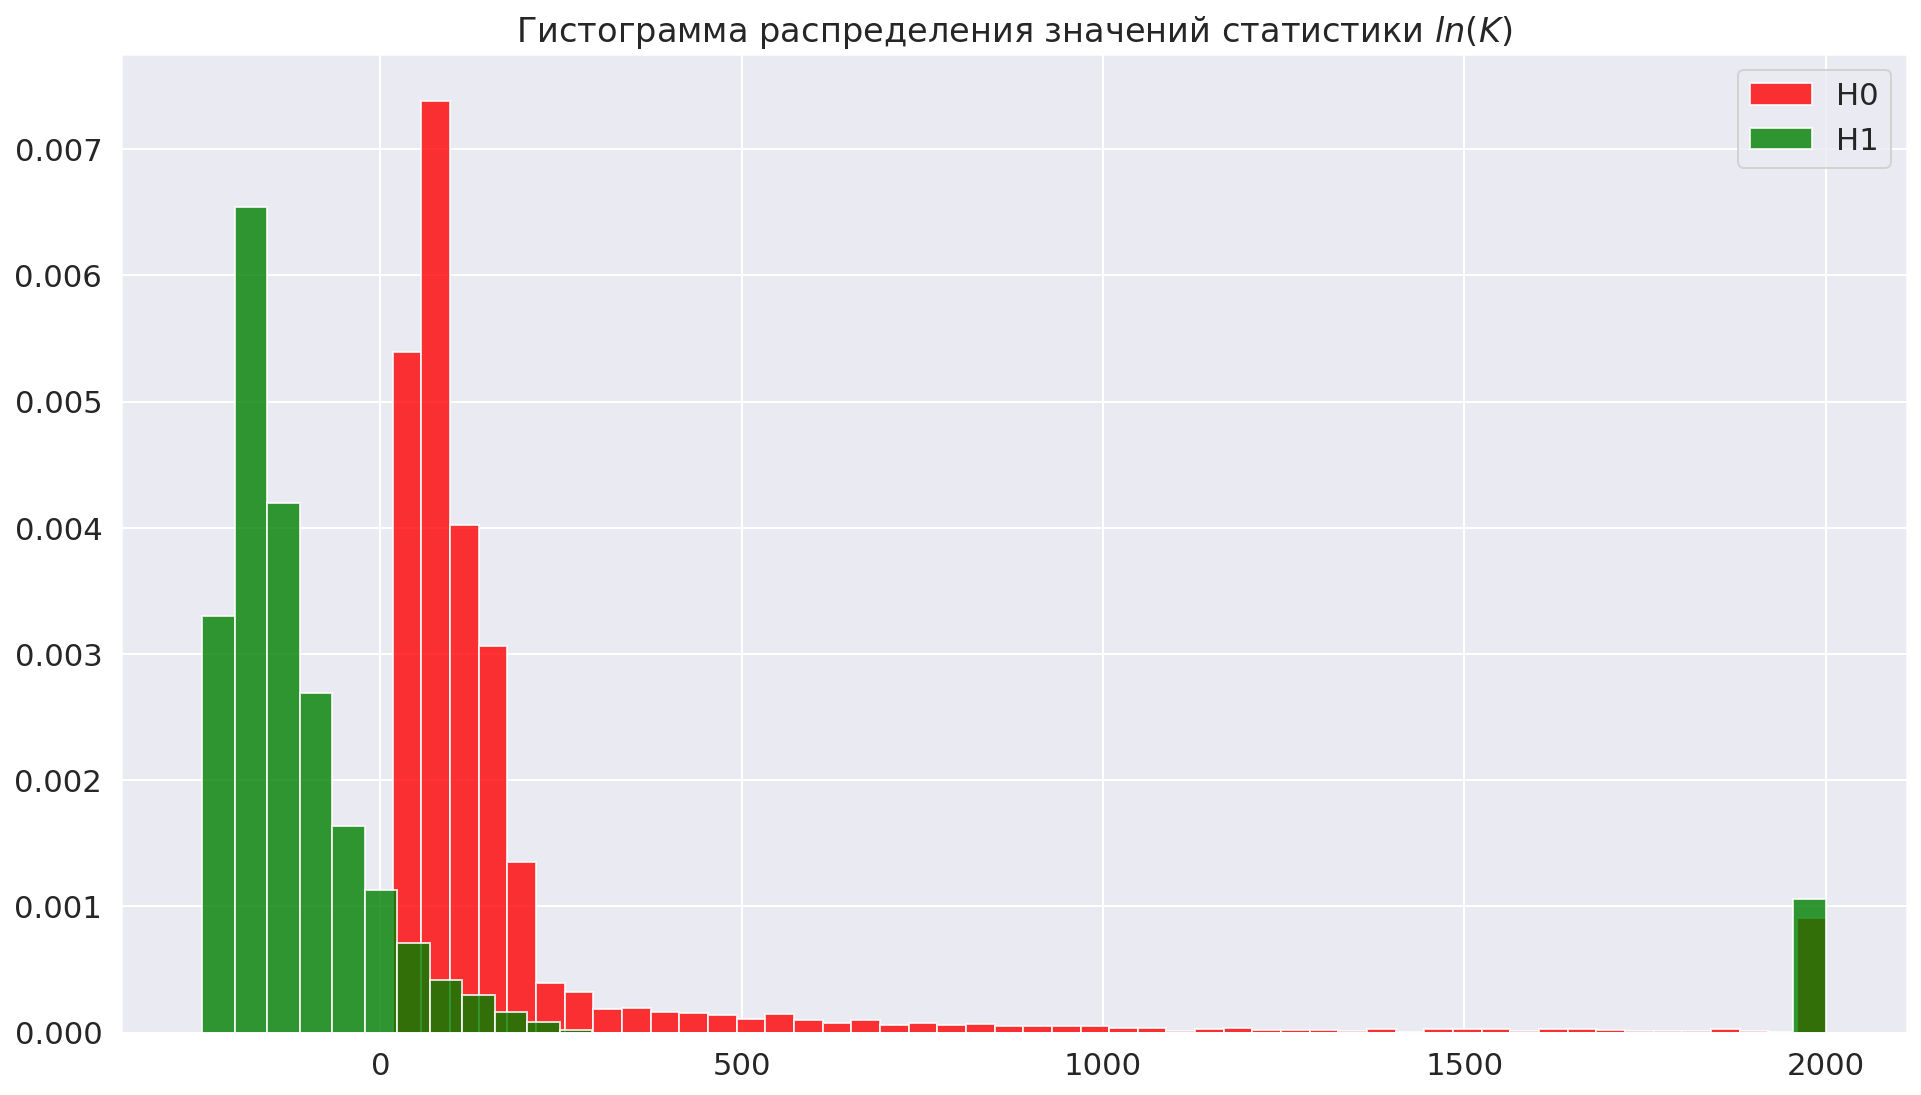

In [7]:
plt.figure(figsize = (16, 9))
plt.hist(k_vals1, density = True, bins = 50, alpha = 0.8, color = 'red', label = 'H0')
plt.hist(k_vals2, density = True, bins = 50, alpha = 0.8, color = 'green', label = 'H1')
plt.title(fr"Гистограмма распределения значений статистики $ln(K)$")
plt.legend()
plt.show()

Исходя из гистограммы, можно сделать вывод, что критерий нужно брать сделующего вида: $ln(K) > z_{\alpha}$, где $z_{alpha}$ -- квантиль эмперического распределения $ln(K)$ при верной гипотезе $H_0$. 

In [8]:
def plot_empirical_function(emprical_function, grid):
    plt.figure(figsize = (16, 9))
    plt.plot(grid,   emprical_function(grid), color = 'red')
    plt.title("График Эмперической функции при верной нулевой гипотезе")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()  

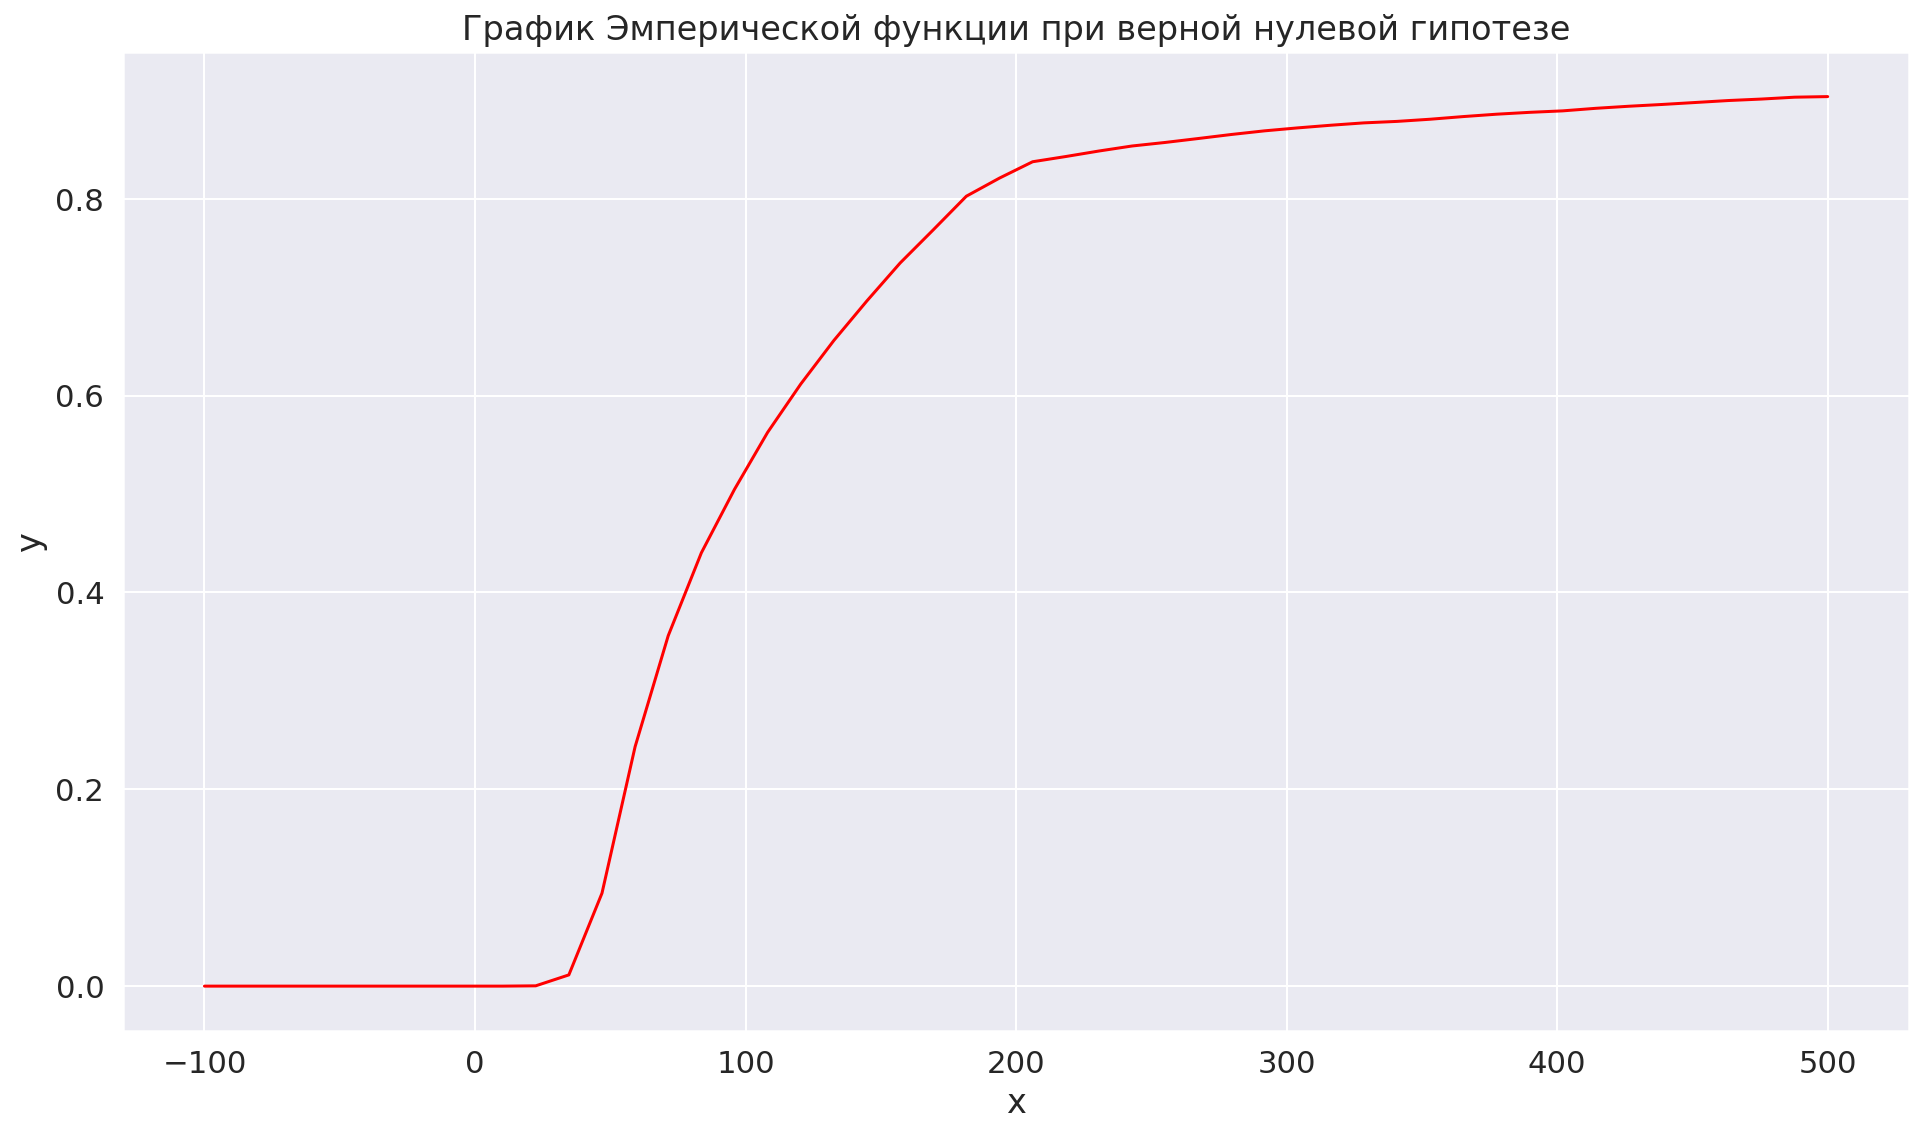

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF  # can be useful, but not necessary

emperical_func = ECDF(k_vals1)
grid = np.linspace(-100, 500)
plot_empirical_function(emperical_func, grid)

Теперь применим критерий для наших данных: 

In [10]:
log_k = calc_log_k(data)
print("Значение логарифма статистики для данных -- ", log_k)
alphas = [0.01, 0.05, 0.1]

for alpha in alphas:
    quant = k_vals1[int(alpha * num_samples)]
    if log_k  > quant:
        print( f"На уровне значимости {alpha} нулевая гипотеза не отвергается, {alpha} квантиль равна {quant}")
    else:
        print(f"На уровне значимости {alpha} нулевая гипотеза отвергается, {alpha} квантиль равна {quant}")

Значение логарифма статистики для данных --  9.818296460171041
На уровне значимости 0.01 нулевая гипотеза отвергается, 0.01 квантиль равна 33.95390523420974
На уровне значимости 0.05 нулевая гипотеза отвергается, 0.05 квантиль равна 42.11648649202198
На уровне значимости 0.1 нулевая гипотеза отвергается, 0.1 квантиль равна 47.34809149167654


### Задача 4

Посчитаем RML-статистику:

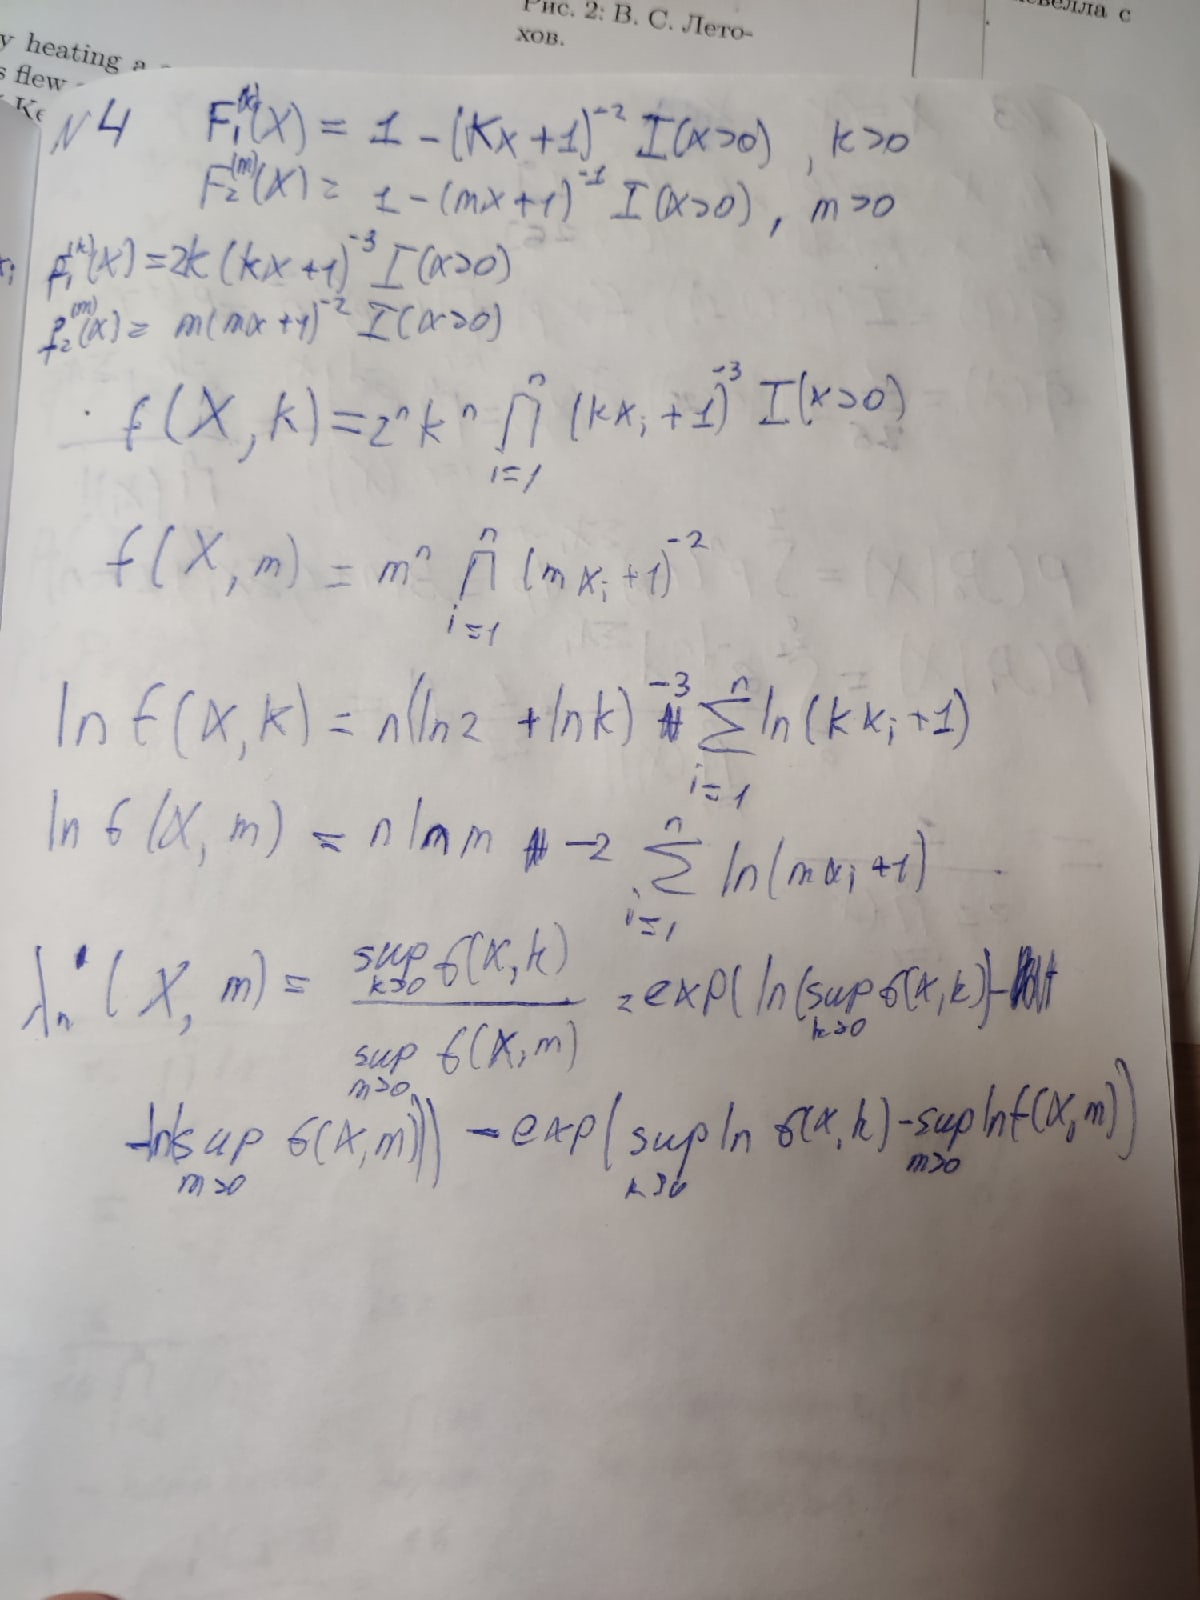

Сначала считаем данные и напишем функцию для подсчета статистики из RML-теста.

In [11]:
xls = pd.read_excel(r"Население.xlsx")
data = np.array(xls["Население"] / np.power(10, 6))

In [12]:
def calc_rml(sample):
    n = len(sample)
    def minimize_first(k):
        return -1 * (n * np.log(2 * np.abs(k)) - 3 * np.sum(np.log(np.abs(k) * sample + 1)))
    def minimize_second(m):
        return -1 *(n * np.log(np.abs(m)) - 2 *  np.sum(np.log(np.abs(m) * sample + 1))) 
    log_first = fmin(minimize_first, 0.1, disp=False)[0] * -1
    log_second = fmin(minimize_second, 0.1, disp=False)[0] * -1
    min_k = minimize(minimize_first, 0.1)
    min_m = minimize(minimize_second, 0.1)
    return np.exp(log_first - log_second), min_k.x, min_m.x

Выборки из распределений будем генерировать с помощью метода обратной функции:

In [13]:
def invert_func_first(x, k):
    return (1 / np.abs(k)) *(np.sqrt(1 / (-x +  1)) - 1)

In [14]:
def invert_func_second(x, m):
    return (1 / np.abs(m)) * (1 / (-x +  1) - 1)

In [15]:
num_samples = 1000
sample_sz = 1000
k_s =   np.append(np.linspace(1, 10, num_samples),np.array([0.2, 0.5, 0.8]))
m_s =   np.append(np.linspace(1, 10, num_samples), np.array([0.2, 0.5, 0.8]))

samples1 = []
samples2 = []

for k, m in zip(k_s, m_s):
    samples1.append(invert_func_first(np.random.rand(sample_sz),k))
    samples2.append(invert_func_second(np.random.rand(sample_sz),m))
    
rmls1 = []
rmls2 = []

for sample1, sample2 in zip(samples1, samples2):
    rmls1.append(calc_rml(sample1)[0])
    rmls2.append(calc_rml(sample2)[0])
rmls1.sort()
rmls2.sort()

Нарисуем гистограммы для распределения значений RML-статистики при гипотезах $H_0$ и $H_1$.

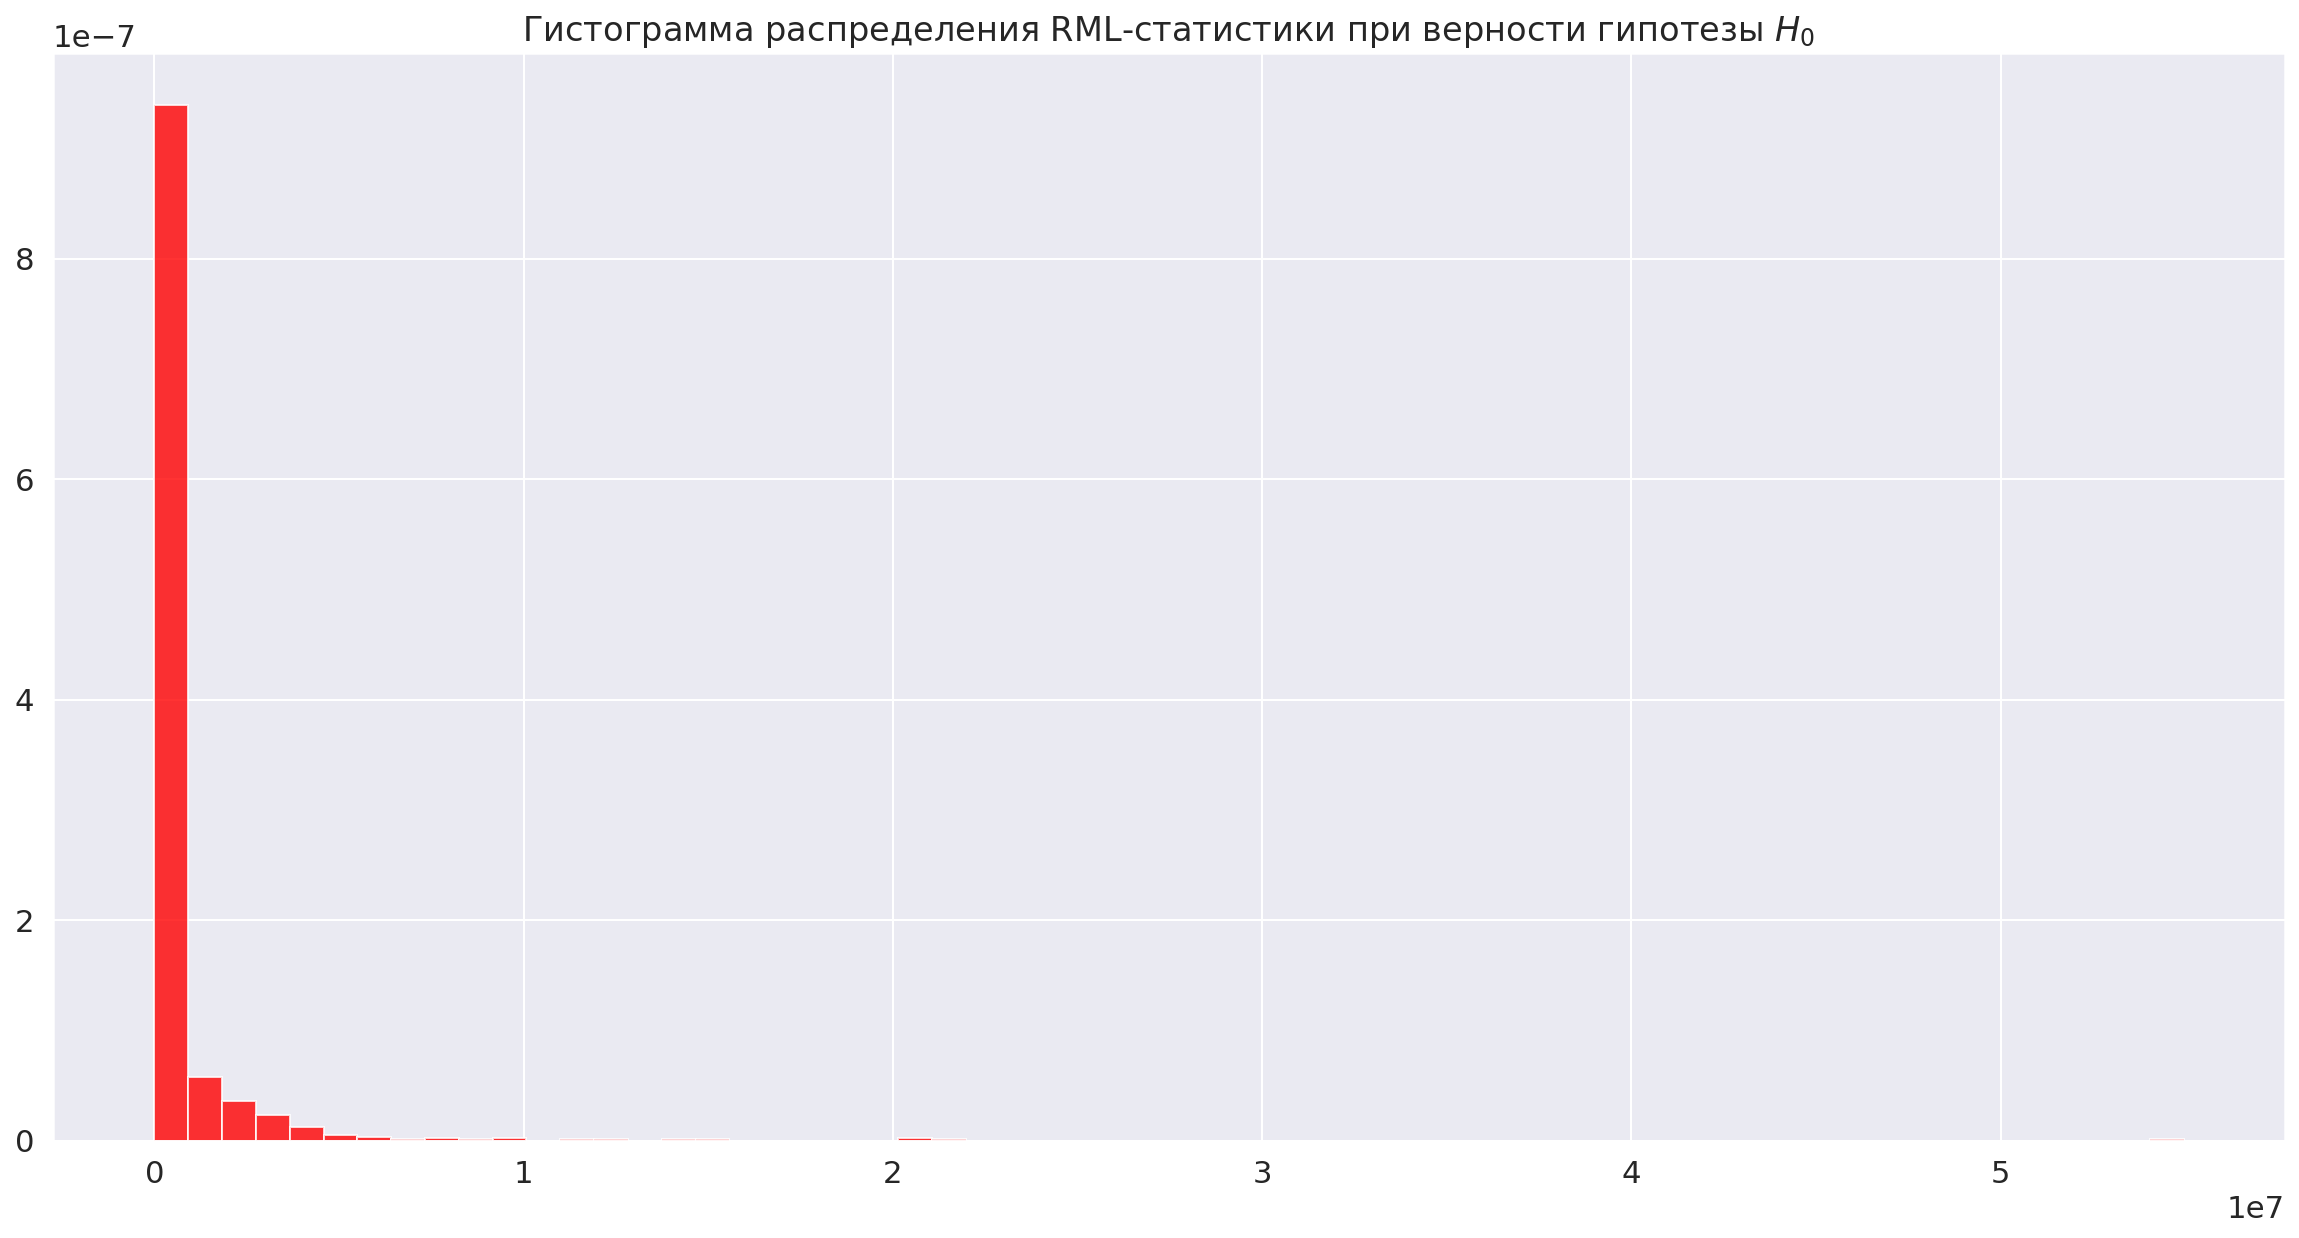

In [16]:
plt.figure(figsize = (20, 10))
plt.hist(rmls1, density = True, bins = 60, alpha = 0.8, color = 'red')
plt.title(fr"Гистограмма распределения RML-статистики при верности гипотезы $H_0$")
plt.show()

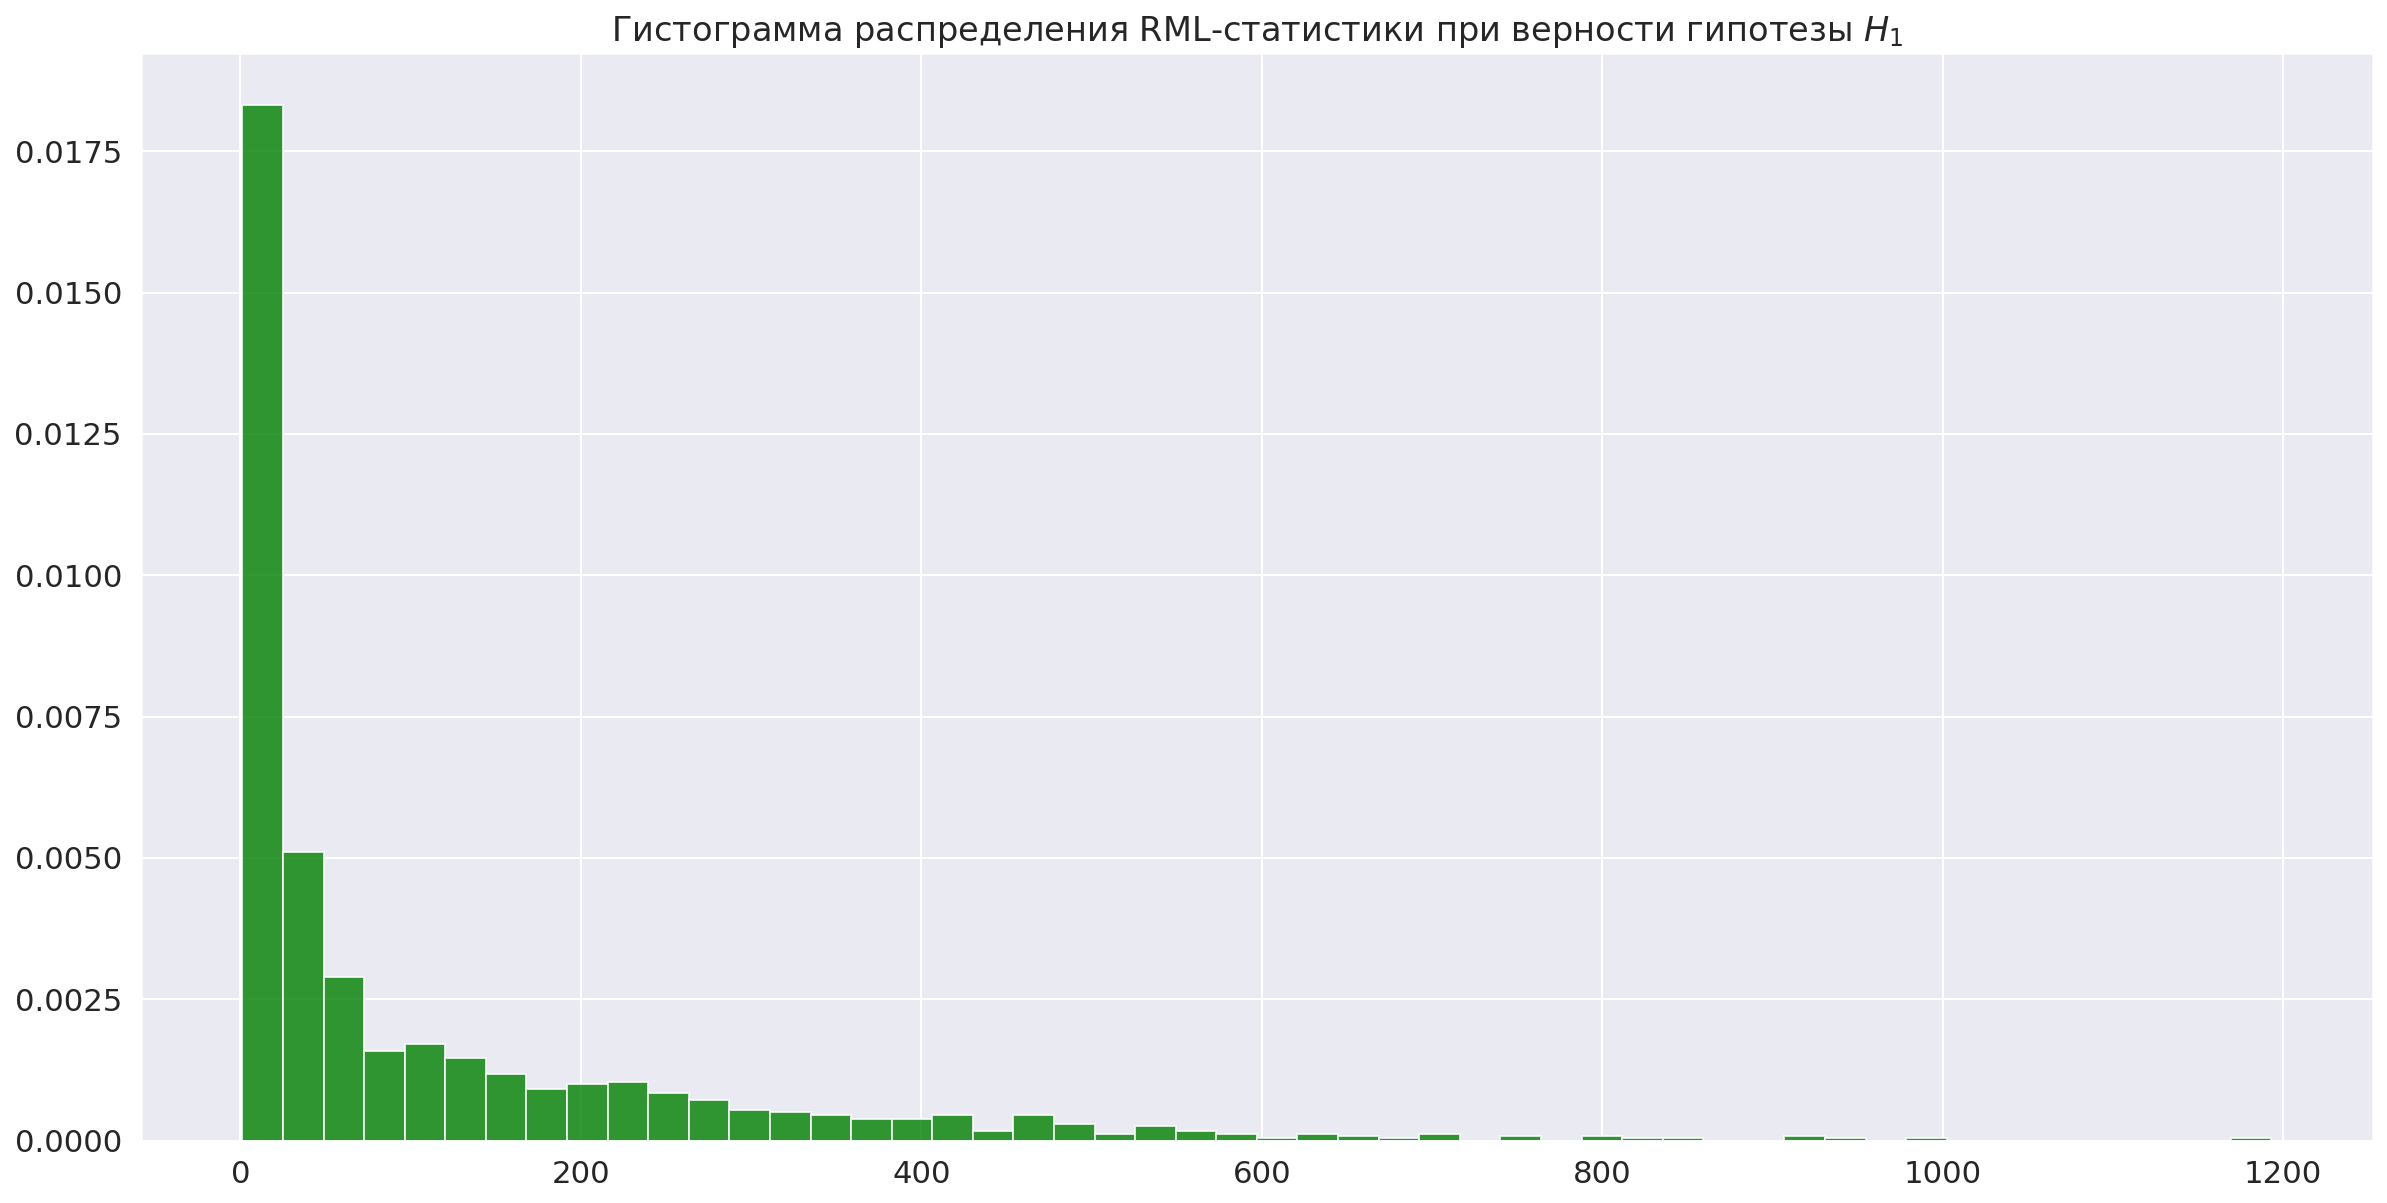

In [17]:
plt.figure(figsize = (20, 10))
plt.hist(rmls2, density = True, bins = 50, alpha = 0.8, color = 'green')
plt.title(fr"Гистограмма распределения RML-статистики при верности гипотезы $H_1$")
plt.show()

Гистограммы показывают, что при обеих гипотезах большая вероятность сконцентрирована в значениях от 0 до 200, однако при первой гипотезе хвост оказывается тяжелей. Не очень понятно, какой критерий выбирать. Если бы исследовали $H_1$ против альернативы $H_0$, то можно было выбирать критерий $\lambda^{'}_{n} > z_{1 - \alpha}$, где $z_{1 - \alpha}$ -- квантиль распределения $\lambda^{'}_{n}$ при верности гипотезы $H_1$, тогда будет вероятность попасть в хвост $H_0$. 

Так, значения $\lambda^{'}_{n}$ при $H_1$ немного меньше, поэтому можно попробовать взять критерий $\lambda^{'}_{n} < z_{\alpha}$, где $z_{\alpha}$ -- $\alpha$-квантиль распределения $\lambda^{'}_{n}$ при верности гипотезы $H_0$.

In [18]:
rml = calc_rml(data)[0]
print("Значение RML-статистики для данных -- ", rml)
alpha = 0.05

quant = rmls1[int(alpha * num_samples)]
if log_k  > quant:
    print( f"На уровне значимости {alpha} нулевая гипотеза не отвергается, {alpha} квантиль равна {quant}")
else:
    print(f"На уровне значимости {alpha} нулевая гипотеза отвергается, {alpha} квантиль равна {quant}")

Значение RML-статистики для данных --  1.236959373368559
На уровне значимости 0.05 нулевая гипотеза не отвергается, 0.05 квантиль равна 8.804248376103814


Попробуем понять, что вторая гипотеза в данном случае лучше первой. Для этого, найдем оптимальные параметры для первой и второй гипотезы и наложим на график плотности гистограммы и сравним.

In [19]:
def pdf_first(k, x):
    return 2 * k * np.power(1 / (k * x + 1), 3)

def pdf_second(k, x):
    return  m* np.power(1 / (m * x + 1), 2)

def draw_density_plot(distr_pdf, distr_param, sample, density_points):
    plt.figure(figsize=(16, 9))
    zeros = np.zeros(len(sample))
    plt.plot(density_points, distr_pdf(distr_param, density_points), color='blue')
    plt.hist(sample, bins=1000, density=True, color="Orange")
    plt.xlabel("x", fontsize=20)
    plt.ylabel("y", fontsize=20)
    plt.xlim((0, 100))
    plt.ylim((0, 0.7))
    plt.scatter(sample, zeros, s = 69, alpha=0.1, color="green")
    plt.show()


[0.07646863] [0.28911605]


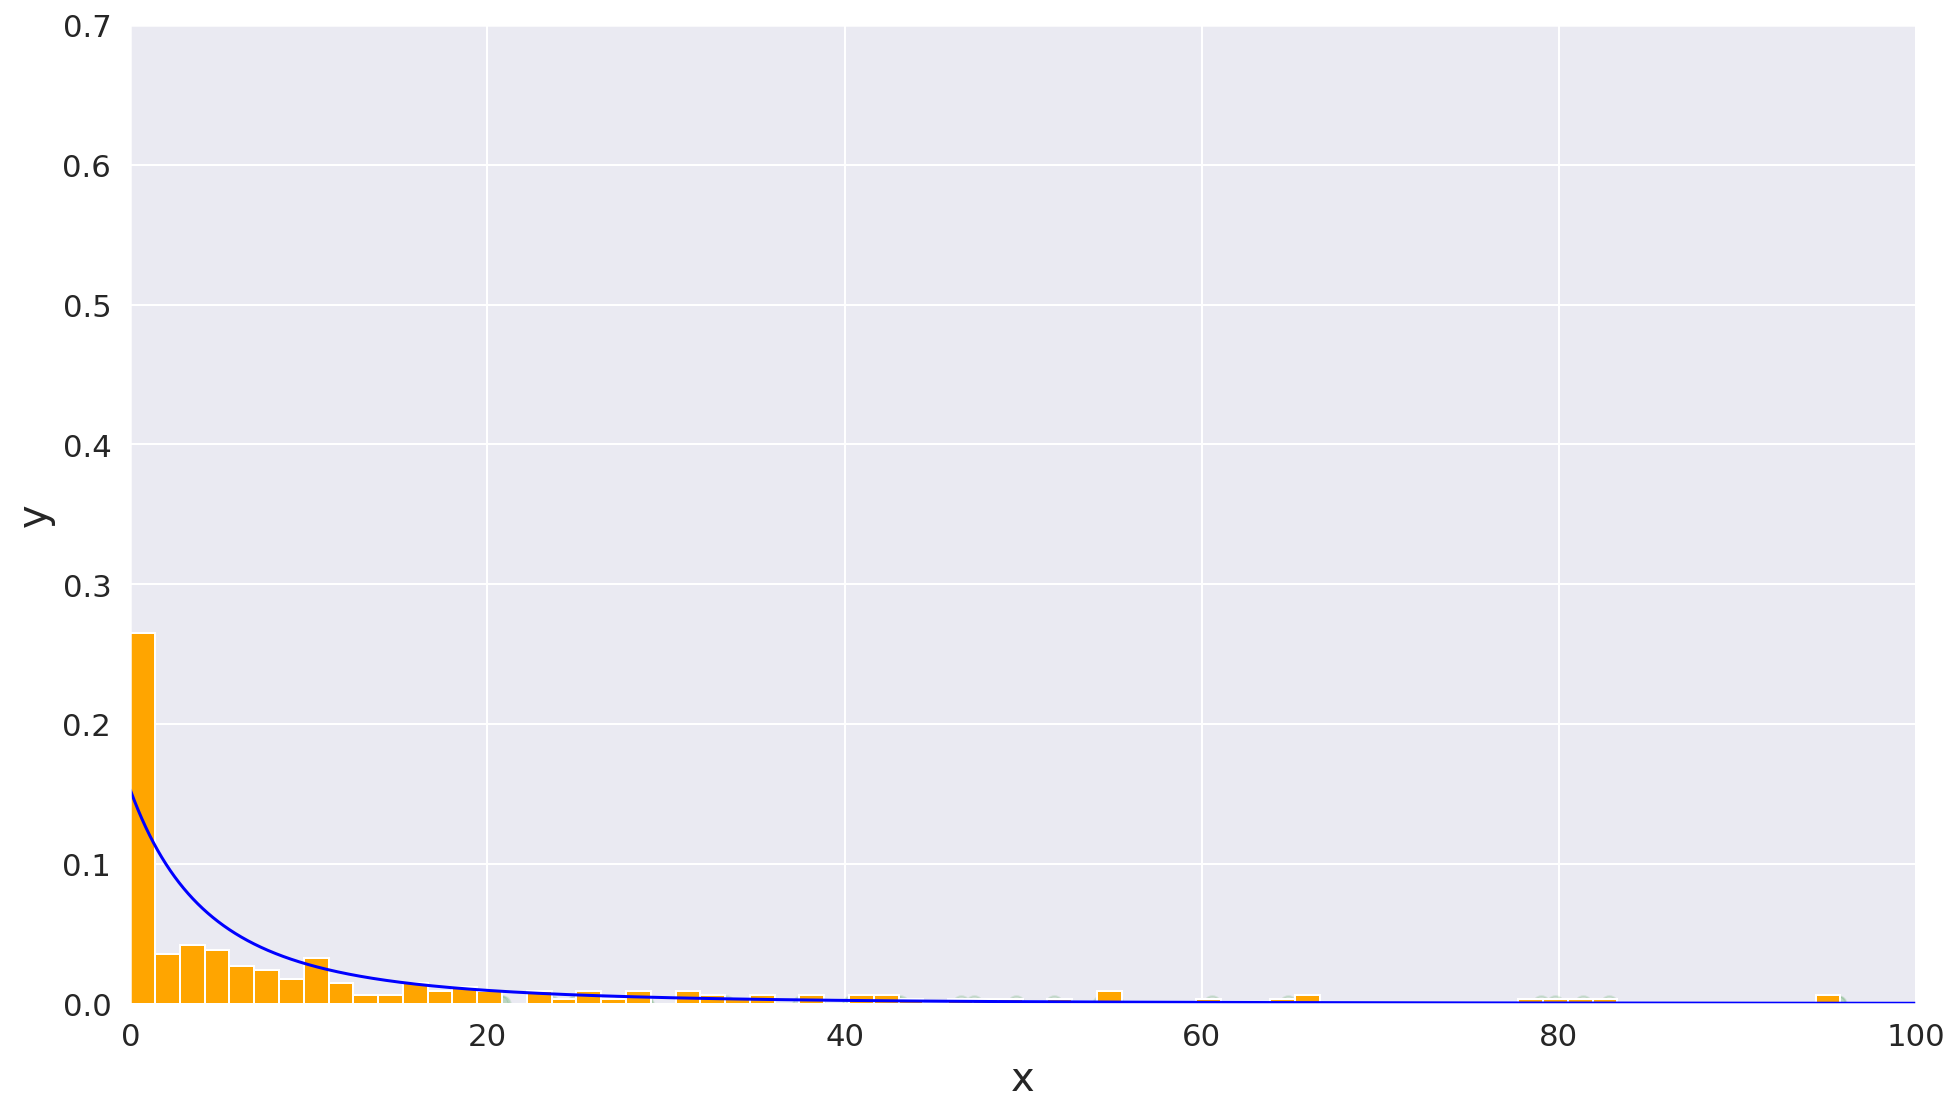

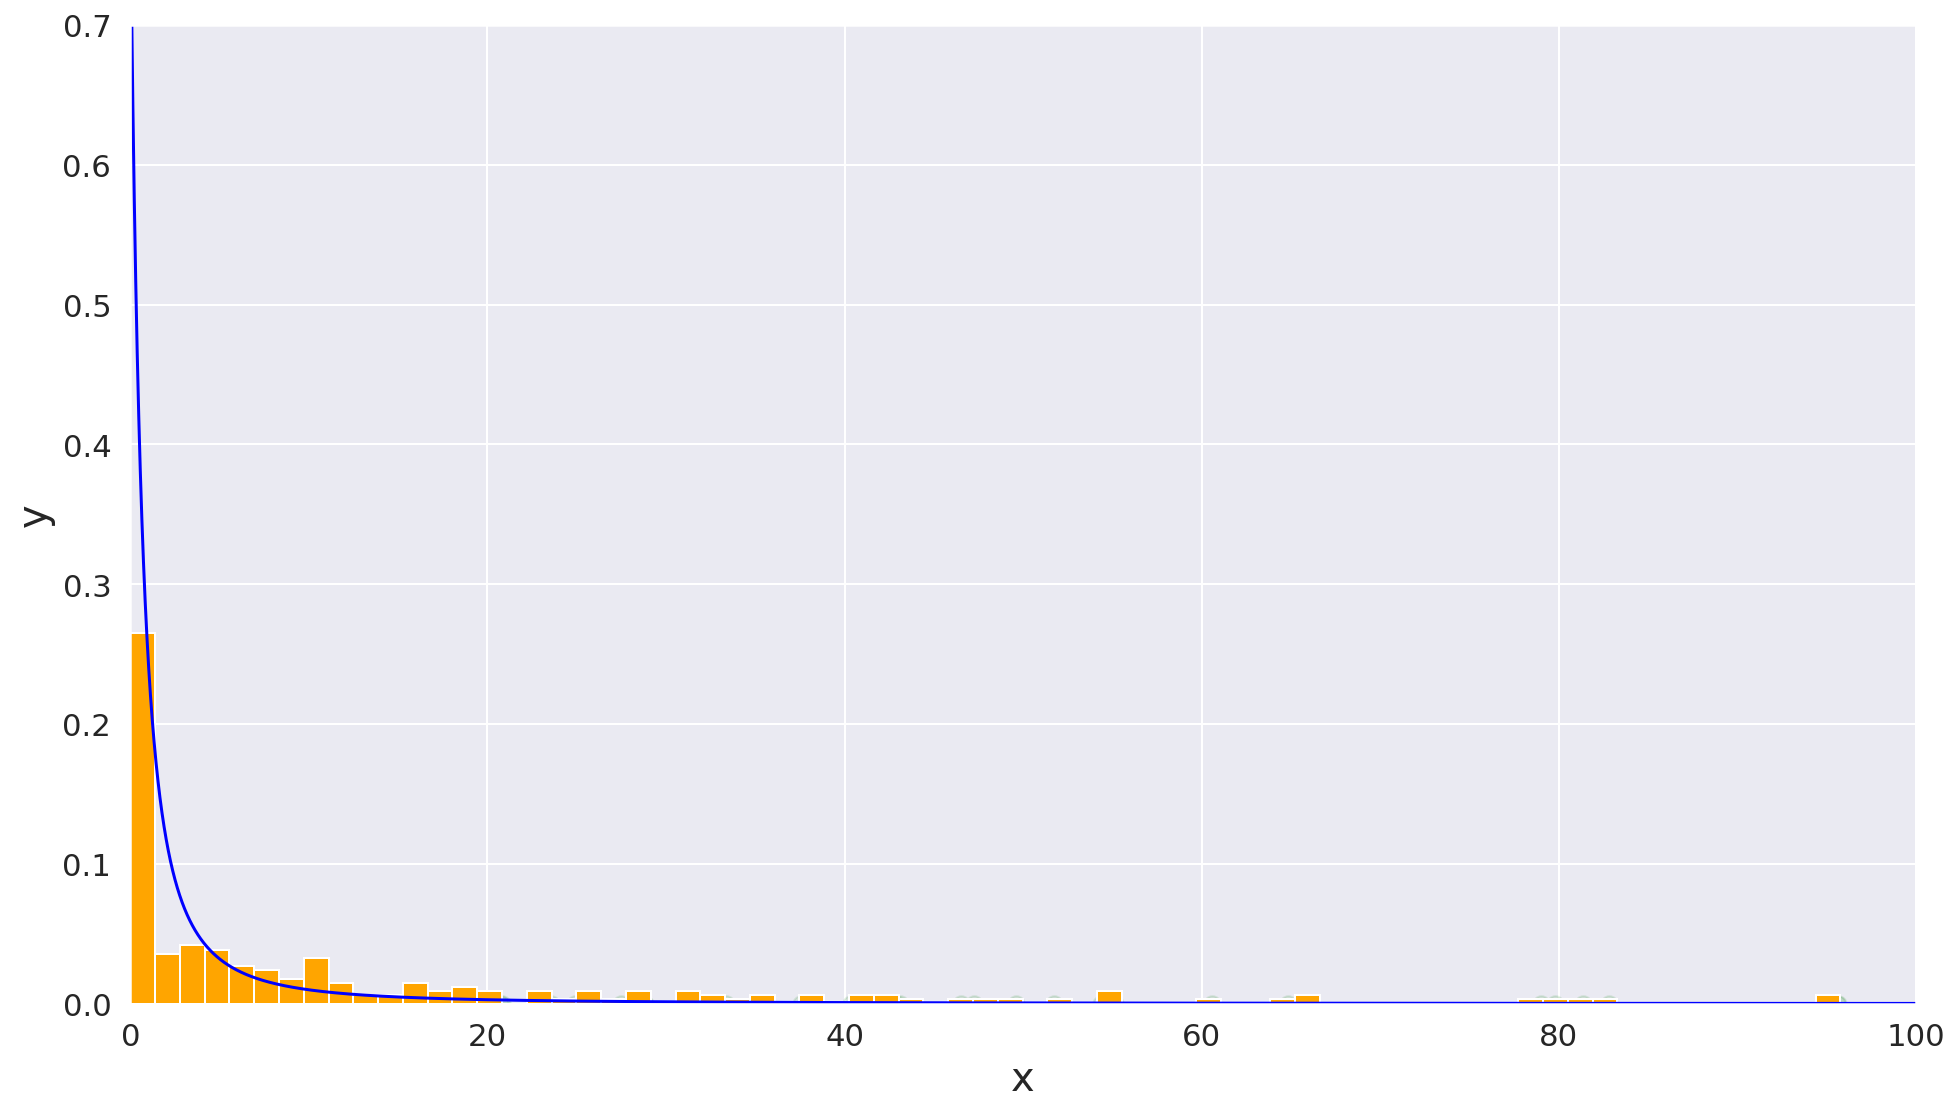

In [20]:
rml_val, min_k, min_m = calc_rml(data)
print(min_k, min_m)
density_points = np.linspace(0, 100, 10**6)

draw_density_plot(pdf_first, min_k, data, density_points)
draw_density_plot(pdf_second, min_m, data, density_points)
    

Как можно заметить, гистограмма на отрезке $[0, 100]$ лучше ложится на второй график плотности. 

### Задача 5

$H_0:$ распределение принадлежит классу бета-распределений.

Рассмотрим такой пайплайн: разбить выборку на 2 части, по одной из них в предположении верности $H_0$ построить оценки параметров, построить доверительный интервал для функции от параметров (в нашем случае для $\frac{\alpha}{\alpha + \beta}$ как матожидания). Затем построить другую оценку параметров на второй части выборки и посмотреть -- попала ли функция от ощценки параметров в доверительный интервал, посчитанный по первой части выборки. Если попали -- не отвергаем $H_0$, иначе -- отвергаем.

Для оценки параметров будем использовать метод моментов для первой части, а для второй -- метод максимального правдоподобия. Немного теоретических выкладок:

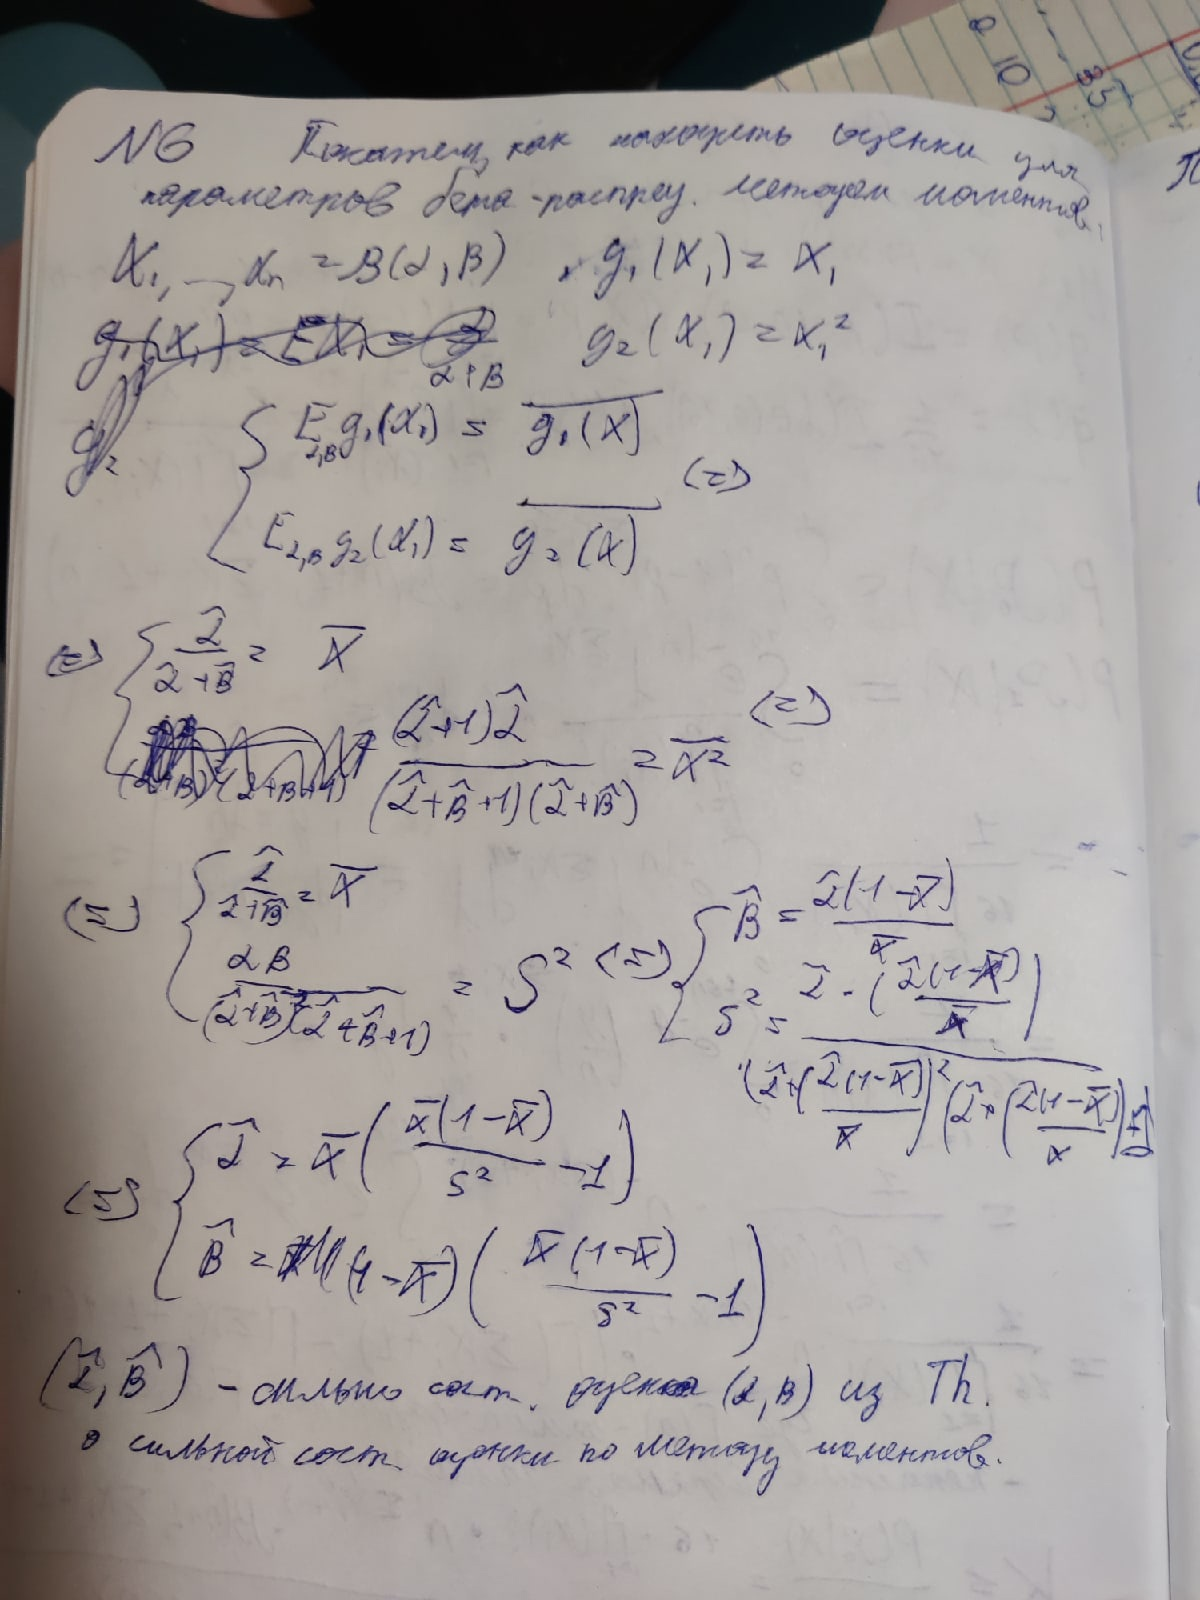

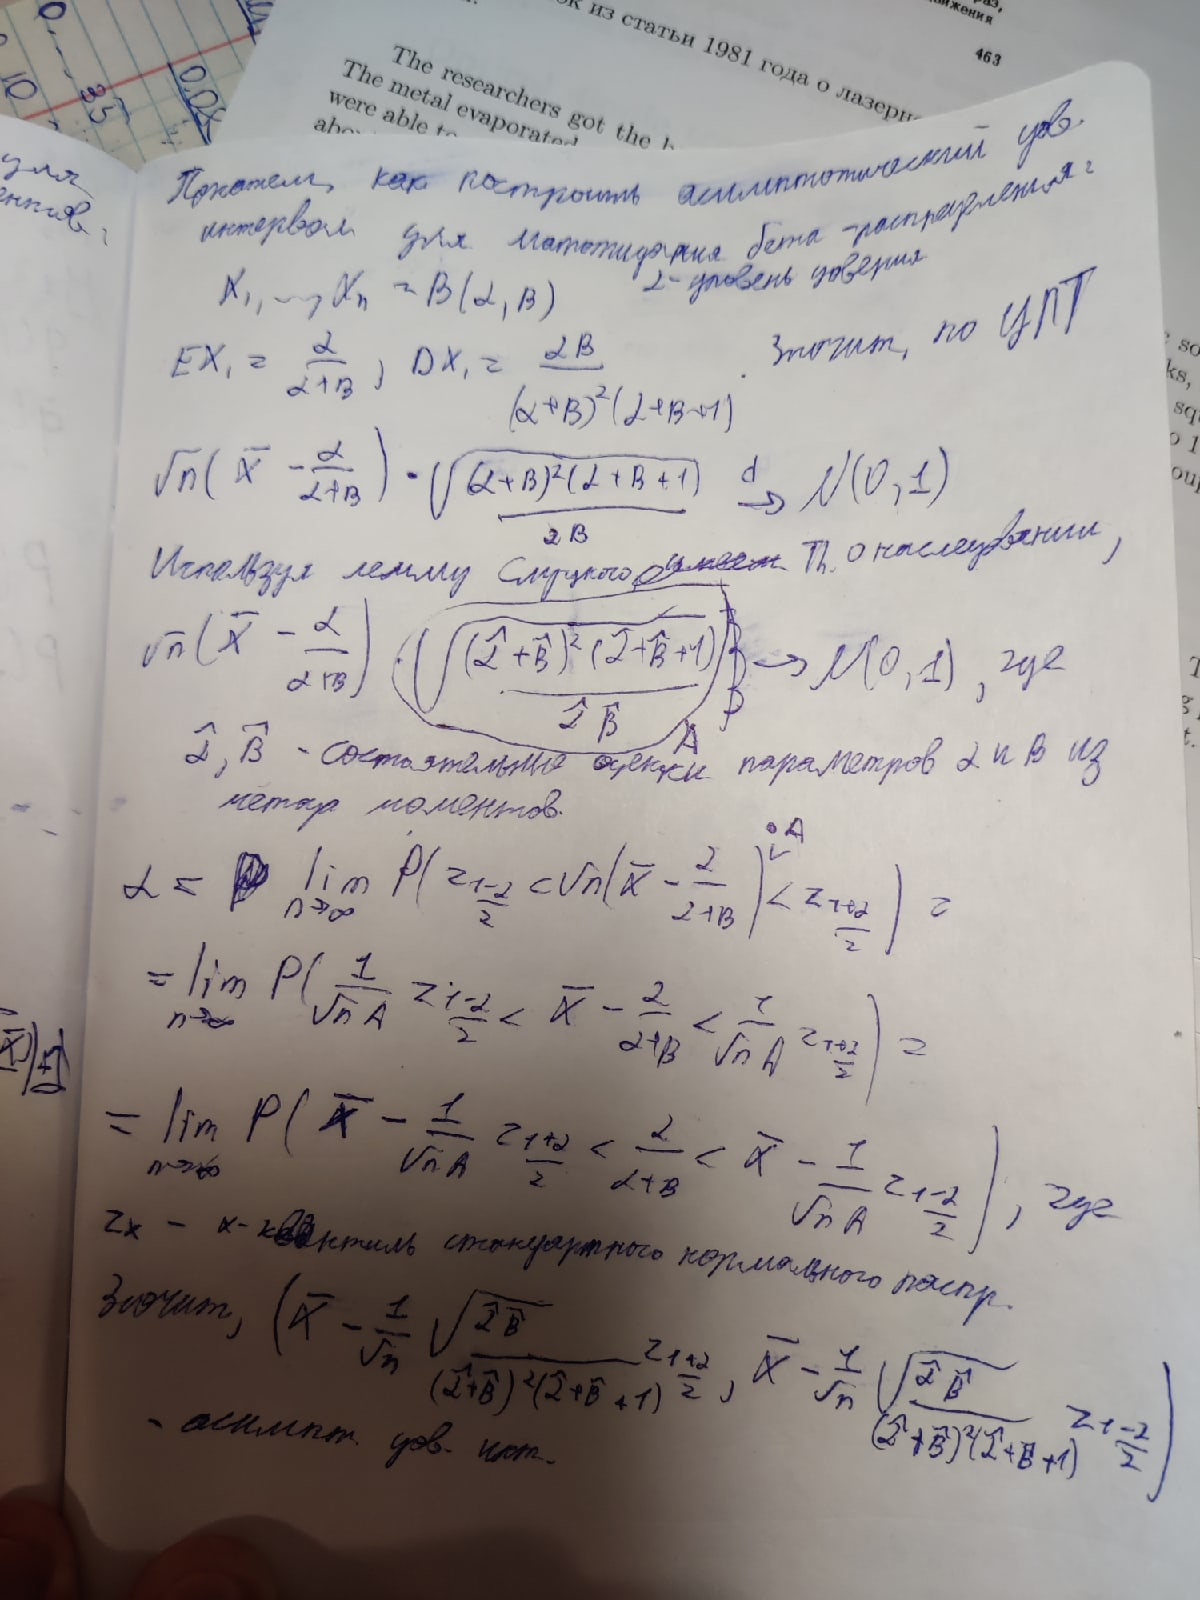

In [21]:
def calc_estimations_moment(sample):
    s_square = np.mean(np.power(sample, 2)) - np.power(np.mean(sample), 2)
    alpha = np.mean(sample) * ((np.mean(sample)*(1 - np.mean(sample))) / s_square - 1)
    beta = (1 - np.mean(sample))* ((np.mean(sample)*(1 - np.mean(sample)))/ (s_square) - 1)
    return alpha, beta

In [22]:
def calc_asymptotic_int(sample):
    al = 0.95
    quant_minus = sps.norm.ppf((1-al)/2)
    quant_plus = sps.norm.ppf((1+al)/2)
    alpha, beta = calc_estimations_moment(sample)
    print("Оценки параметров методом моментов -- " , alpha, beta)
    var = np.sqrt(alpha * beta / (np.power(alpha + beta, 2) * (alpha + beta + 1)) / len(sample))
    print("Дисп",var)
    return np.mean(sample) - var * quant_plus, np.mean(sample) - var * quant_minus

In [23]:
def calc_max_likelihood_est(sample):
    def func_to_minimize(x):
        return -1 * (-1 * len(sample) * spss.betaln(x[0] ,x[1]) + (x[0] - 1) * np.sum(np.log(sample)) +
                     (x[1] - 1) * np.sum(np.log(1 - sample)))
    params = minimize(func_to_minimize, [2, 2], method = 'Nelder-Mead')
    print(params.message,  params.success)
    if not params.success:
        return None, None
    return params.x[0], params.x[1]


In [24]:
def full_process(sample):
    n = len(sample)
    first_part = sample[:int(n / 2)]
    second_part =sample[int(n / 2):]
    left, right = calc_asymptotic_int(first_part)
    print(f"Доверительный интервал для матожидания -- ({left}, {right})")
    alpha_mle, beta_mle = calc_max_likelihood_est(second_part)
    print(alpha_mle, beta_mle)
    if alpha_mle is not None and beta_mle is not None:
        mean_est = alpha_mle / (alpha_mle + beta_mle)
        print("Оценка по методу максимального правдоподобия для матожидания --", mean_est)
        if left < mean_est and mean_est < right:
            print("Распределение скорее всего принадлежит семейству бета-распределений")
            return
    
    print("Распределение скорее всего не принадлежит семейству бета-распределений")
    

Теперь посчитаем асимптотический доверительный интервал для $\frac{\alpha}{\alpha + \beta}$ уровня доверия 0.95 испльзуя ЦПТ, лемму слуцкого и состоятельность оценок $\alpha$ и $\beta$ (состоятельность берется из теоремы о сильной состоятельности оценки по методу моментов)

In [25]:
full_process(sps.beta(5, 25).rvs(400))

Оценки параметров методом моментов --  5.5202209821268875 27.464125876259857
Дисп 0.004527920278142805
Доверительный интервал для матожидания -- (0.15848424761036928, 0.17623336895042624)
Optimization terminated successfully. True
4.555549782139851 23.5349679933194
Оценка по методу максимального правдоподобия для матожидания -- 0.16217393422771728
Распределение скорее всего принадлежит семейству бета-распределений


In [26]:
data = pd.read_csv("2.5.csv")
data.head()

,values
0,0.988
1,0.888
2,0.947
3,0.917
4,0.826


In [27]:
full_process(data["values"])

Оценки параметров методом моментов --  4.3074576689178885 1.0094067005419503
Дисп 0.015604046750763087
Доверительный интервал для матожидания -- (0.7795666303554252, 0.8407333696445749)
Optimization terminated successfully. True
5.323843112357844 1.1387959259579512
Оценка по методу максимального правдоподобия для матожидания -- 0.8237877871243868
Распределение скорее всего принадлежит семейству бета-распределений


Покажем, что на других распределениях также ответ будет правильный.

In [28]:
full_process(sps.uniform(0.3, 0.7).rvs(10000))

Оценки параметров методом моментов --  2.882586806336309 1.5651719453684207
Дисп 0.0028935904745992884
Доверительный интервал для матожидания -- (0.6424273986847041, 0.6537700649171497)
Optimization terminated successfully. True
2.736388486125465 1.4015138830947271
Оценка по методу максимального правдоподобия для матожидания -- 0.6612984652514048
Распределение скорее всего не принадлежит семейству бета-распределений


In [29]:
full_process(sps.norm(0.5, 0.25).rvs(10000))

Оценки параметров методом моментов --  1.532242648869934 1.5347469253555095
Дисп 0.00350629399445479
Доверительный интервал для матожидания -- (0.4927195270913578, 0.5064639469880388)
Maximum number of function evaluations has been exceeded. False
None None
Распределение скорее всего не принадлежит семейству бета-распределений


In [30]:
full_process(sps.cauchy(loc = 0.5, scale = 0.05).rvs(400))

Оценки параметров методом моментов --  -0.5327308272593352 -0.3538000519101754
Дисп 0.10279811481812956
Доверительный интервал для матожидания -- (0.399435665144788, 0.8023968705890824)
Maximum number of function evaluations has been exceeded. False
None None
Распределение скорее всего не принадлежит семейству бета-распределений


Почему критерий хотя бы немного работает? Если распределение принадлежит бета-семейству, то понятно почему происходит детектирование. Рассмотрим случай, если семейство не принадлежит бета-распределению. Тогда, так как оценки методом моментов и методом максимального правдоподобия сильно отличаются (для второй нету аналитического выражения), то часто будут получаться совершенно различные значения оценок. Более того, оценка максимального правдоподобия, если рассматривать логарифм функции правдоподобия, содержит логарифм, который будет просто умирать если в выборке есть отрицательные значения, что хорошо. Если же значения в выборке будут больше единицы, эти логарифмы станут положительными, поэтому будут получаться какие-то очень странные значения параметров.